In [91]:
%matplotlib inline
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [92]:
class Grid():
    def __init__(self, n, m, n_home, m_home, delta):
        self.pheremones = np.zeros((n,m),dtype=float)
        self.food = np.zeros((n,m),dtype=float)
        self.occupancy = np.zeros((n,m), dtype=float)
        
        self.home = (n_home, m_home)
        self.food_drop = 0
        
        self.food[55:65, 55:65] = 1  # For testing 
    
    def evaporate(self):
        self.pheremones -= delta*self.pheremones

In [118]:
class Ant():
    def __init__(self, n, m, n_home, m_home, q, sigma_1, sigma_2, mu, grid):
        self.loc = (n, m)
        self.home = (n_home, m_home)
        
        self.dir = self.randomize_dir(grid)
        
        self.hasfood = False
        self.removed = False
    
    def randomize_dir(self, grid):
        p0 = grid.pheremones[self.loc[0], self.loc[1]+1] + grid.pheremones[self.loc[0]+1, self.loc[1]+1] + grid.pheremones[self.loc[0]-1, self.loc[1]+1]
        p1 = grid.pheremones[self.loc[0]+1, self.loc[1]] + grid.pheremones[self.loc[0]+1, self.loc[1]+1] + grid.pheremones[self.loc[0]+1, self.loc[1]-1]
        p2 = grid.pheremones[self.loc[0], self.loc[1]-1] + grid.pheremones[self.loc[0]+1, self.loc[1]-1] + grid.pheremones[self.loc[0]-1, self.loc[1]-1]
        p3 = grid.pheremones[self.loc[0]-1, self.loc[1]] + grid.pheremones[self.loc[0]-1, self.loc[1]+1] + grid.pheremones[self.loc[0]-1, self.loc[1]-1]
        
        ps = p0 + p1 + p2 + p3
        if ps != 0:
            p0 /= ps
            p1 /= ps
            p2 /= ps
            p3 /= ps
        
            did = np.random.choice([0,1,2,3], 1, p=[p0,p1,p2,p3])
        else:
            did = np.random.choice(4, 1)
        if did == 0:
            direction = (0, 1)
        elif did == 1:
            direction = (1, 0)
        elif did == 2:
            direction = (0, -1)
        elif did == 3:
            direction = (-1, 0)
        return direction
    
    def move(self, grid):
        if self.loc[0] == 0 or self.loc[1] == 0 or self.loc[0] == grid.occupancy.shape[0]-1 or self.loc[1] == grid.occupancy.shape[1]-1:
            self.removed = True
            print("Boarder!")
        if not self.removed:
            left_loc = (self.loc[0]+self.dir[1]+self.dir[0], self.loc[1]-self.dir[0]+self.dir[1])
            front_loc = (self.loc[0]+self.dir[0], self.loc[1]+self.dir[1])
            right_loc = (self.loc[0]-self.dir[1]+self.dir[0], self.loc[1]+self.dir[0]+self.dir[1])
        
            lp = grid.pheremones[left_loc[0], left_loc[1]]
            fp = grid.pheremones[front_loc[0], front_loc[1]]
            rp = grid.pheremones[right_loc[0], right_loc[1]]
            
            p_m = 0.5 * (1 + np.tanh((lp + fp + rp)/100 - 1))
            if np.random.choice(2, 1, p=[1-p_m,p_m]):
                c = (mu + lp)**2 + (mu + fp)**2 + (mu + rp)**2
                p_left = 1/c * (mu + lp)**2
                p_front = 1/c * (mu + fp)**2
                p_right = 1/c * (mu + rp)**2
                
                next_loc = np.random.choice(["left_loc","right_loc","front_loc"], 1, p=[p_left,p_right,p_front])
                if next_loc == "left_loc" and grid.occupancy[left_loc[0], left_loc[1]] < Am:
                    grid.occupancy[self.loc[0], self.loc[1]] -= 1
                    self.loc = left_loc
                    grid.occupancy[self.loc[0], self.loc[1]] += 1
                elif next_loc == "front_loc" and grid.occupancy[front_loc[0], front_loc[1]] < Am:
                    grid.occupancy[self.loc[0], self.loc[1]] -= 1
                    self.loc = front_loc
                    grid.occupancy[self.loc[0], self.loc[1]] += 1
                elif next_loc == "right_loc" and grid.occupancy[right_loc[0], right_loc[1]] < Am:
                    grid.occupancy[self.loc[0], self.loc[1]] -= 1
                    self.loc = right_loc
                    grid.occupancy[self.loc[0], self.loc[1]] += 1

                    
                if grid.food[self.loc[0], self.loc[1]] > 0:
                    if not self.hasfood:
                        g.food[self.loc[0], self.loc[1]] -= 1
                        self.dir = (self.dir[0]*-1, self.dir[1]*-1) # Flips direction
                        self.hasfood = True
                        
                        
                if (self.home[0]-4 < self.loc[0] < self.home[0]+4) and (self.home[1]-4 < self.loc[1] < self.home[1]+4) and self.hasfood:
                    self.hasfood = False
                    grid.occupancy[self.home[0], self.home[1]] -= 1
                    grid.food_drop += 1
                    self.removed = True
                    print("Brought back food!")
                    
                    
            if self.hasfood:
                if grid.pheremones[self.loc[0], self.loc[1]] < sigma_2:
                    grid.pheremones[self.loc[0],self.loc[1]] += q
            else:
                if grid.pheremones[self.loc[0], self.loc[1]] < sigma_1:
                    grid.pheremones[self.loc[0], self.loc[1]] += 1.
    
    def plot(self):
        if self.hasfood:
            color = 'red'
        else:
            color = 'green'
        plt.scatter(self.loc[0], self.loc[1], color=color)
        

In [127]:
def simulate(g, ants, q, sigma_1, sigma_2, mu, delta, Am, Nb, iterations=100):
    fitness = 0
    fig, _ = plt.subplots(figsize=(10, 20))
    
    for _ in range(iterations):
        for _ in range(Nb):
            if g.occupancy[g.home[0], g.home[1]] < Am:
                ants.append(Ant(g.home[0], g.home[1], g.home[0], g.home[1], q, sigma_1, sigma_2, mu, g))
                g.occupancy[g.home[0], g.home[1]] += 1
                
        for ant in ants:
            ant.move(g)
            if ant.removed:
                ants.remove(ant)
                continue

        g.evaporate()
        
        fitness += (g.food_drop / np.sum(g.occupancy))
        g.food_drop = 0
        
        # Plot
        plt.imshow(g.food.T)
#         plt.imshow(g.pheremones.T)
        plt.scatter(g.home[0], g.home[1], color='blue')
        for ant in ants:
            ant.plot()
        
        # Animaiton part
        clear_output(wait=True) # Clear output for dynamic display
        display(fig)            # Reset display
        fig.clear()             # Prevent overlapping and layered plots
        time.sleep(0.0001)      # Sleep to allow animation to catch up
    
    return fitness

KeyboardInterrupt: 

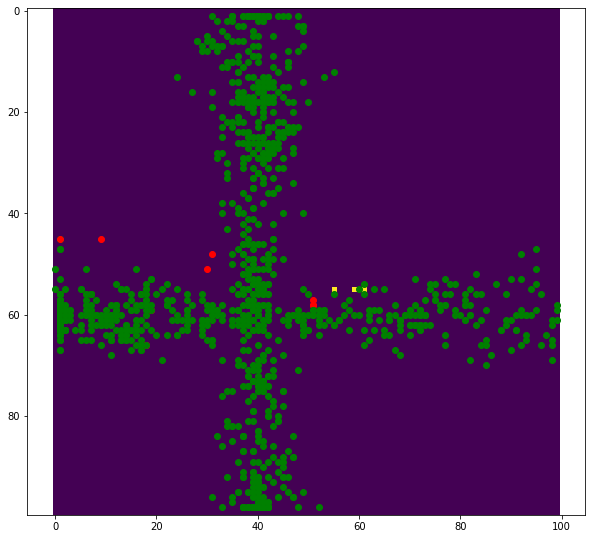

In [128]:
q = 46
sigma_1 = 431
sigma_2 = 592
mu = 47.5
delta = 0.0368

Am = 15
Nb = 5

m = 40
n = 60

g = Grid(100, 100, m, n, delta)
ants = list()

simulate(g, ants, q, sigma_1, sigma_2, mu, delta, Am, Nb, iterations=1000)